In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt

from clipppy.commands.nre.validate import MultiNREValidator, MultiNRECoverage
# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy

from uplot import imshow_with_cbar
from uplot.tikz.utils import points3d_to_metacoords, points_to_coords
from uplot.tikz.pgfdata import PGFData, to_pgfdata


torch.set_default_tensor_type(torch.cuda.FloatTensor)

sns.reset_orig()

In [2]:
from libsimplesn import SimpleSN

FINAL = False
LATENT = False

simplesn = SimpleSN(survey='pantheon-g10', datatype='photoz', N=100_000, suffix=0, version=0)
config = simplesn.config('simplesn.yaml', gen=True, latent=LATENT)
defs = config.kwargs['defs']
nre = config.lightning_nre



COSMOGROUP = 'Om0', 'Ode0'
LATENT_PARAMS = 'M0',

groups = [COSMOGROUP]
if not FINAL:
    groups.extend(key for key in nre.param_names if key not in COSMOGROUP and key not in LATENT_PARAMS)

In [3]:
STEP_TYPE = 'final' if FINAL else 'all'

BOUNDS = simplesn.zoom_bounds
ZOOM_LEVEL = len(BOUNDS) - 2 if FINAL else 4

nre.dataset_config.kwargs['ranges'].update(BOUNDS[ZOOM_LEVEL])

# nre.dataset_config.kwargs['ranges'].update({
#     key: itemgetter('lower', 'upper')(val)
#     for key, val in simplesn.hdi_bounds[(simplesn.datatype, simplesn.N)].to_dict().items()
# })

#### Prepare plotting

In [4]:
from clipppy.utils.messengers import CollectSitesMessenger
from typing import Iterable
from clipppy.commands.nre import ClipppyDataset
from collections import defaultdict
from clipppy.utils.plotting.nre import MultiNREPlotter


def get_priors(param_names: Iterable[str], dataset: ClipppyDataset):
    with CollectSitesMessenger(*param_names) as trace:
        dataset.get_trace()
    return {name: site['fn'] for name, site in trace.items()}


priors = get_priors(set(nre.param_names) - set(LATENT_PARAMS), nre.dataset.dataset)
ranges = {key: (prior.support.lower_bound, prior.support.upper_bound) for key, prior in priors.items()}


def nrepper(ngrid=256, ngrid_cosmo=32):
    return MultiNREPlotter(
        groups=groups,
        grid_sizes=defaultdict(lambda: ngrid, Om0=ngrid_cosmo, Ode0=ngrid_cosmo),
        priors=priors, ranges=ranges, labels=defs['labels']
    )

ranges

{'sigma_z': (tensor(0.0388), tensor(0.0413)),
 'Om0': (0.17451095581054688, 0.3820991516113281),
 'Ode0': (0.41747283935546875, 0.8431930541992188),
 'alpha': (0.12662039697170258, 0.15788179636001587),
 'beta': (2.877440929412842, 3.20969295501709),
 'mean_M0': (-19.526729583740234, -19.44125747680664),
 'sigma_res': (tensor(0.0293), tensor(0.1432)),
 'mean_x1': (-0.030559882521629333, 0.02349245175719261),
 'log10_R_x1': (-0.007149392738938332, 0.00932353362441063),
 'mean_c': (-0.002460464835166931, 0.004179413430392742),
 'log10_R_c': (-1.006495475769043, -0.988019585609436)}

In [5]:
MAX_BATCH = 32 if simplesn.N > 50_000 else 64

LOGDIR = f'lightning_logs/{simplesn.basedata_prefix}/{STEP_TYPE}-{ZOOM_LEVEL}/step/version_0'
NSTEPS = 19999
LOGDIR

'lightning_logs/pantheon-g10-100000-0-photoz/all-4/step/version_0'

In [ ]:
ckpt = torch.load(f'{LOGDIR}/checkpoints/epoch=0-step={NSTEPS}.ckpt')
nre.head, nre.tail = ckpt['clipppy_nets']
nre = nre.cuda().eval()

## Coverage

In [ ]:
coverage = MultiNRECoverage(1024 // MAX_BATCH, MAX_BATCH, nre.dataset, nrepper(ngrid_cosmo=64))

#### Generate

In [ ]:
confidence = {
    group: coverage.coverages[group].confidence(nre.head, tail)
    for group, tail in coverage.nrep.subtails(nre.tail).items()
    if group == COSMOGROUP
}

In [ ]:
torch.save(confidence, f'{LOGDIR}/confidence.pt')

In [ ]:
confidence = torch.load(f'{LOGDIR}/confidence.pt')

### Confidence regions

In [ ]:
from itertools import chain


P = 0.68, 0.95
clrs = ((0, 0.66, 0), (0, 1, 0))

imkwargs = dict(origin='lower', extent=tuple(chain(*itemgetter(*COSMOGROUP)(coverage.nrep.ranges))))

SEEDS = [25, 42, 4264]
PARAMS = (
    {'Om0': 0.26, 'Ode0': 0.55},
    {'Om0': 0.30, 'Ode0': 0.70}, 
    {'Om0': 0.355, 'Ode0': 0.55},
)
PERC = []
CONTOURS = []
MASKS = []

In [ ]:
from more_itertools import always_reversible

import pyro

from clipppy.utils.plotting.nre import to_percentiles

fig, axs = plt.subplots(1, len(PARAMS), sharex='all', sharey='all', figsize=(3*len(PARAMS)+1, 4), dpi=150)

for ax, params, seed in zip(axs, PARAMS, SEEDS):
    torch.manual_seed(seed)
    
    with pyro.condition(data=params):
        params, obs = next(iter(nre.dataset))
    # params, obs = {'Om0': 0.3, 'Ode0': 0.7}, {key: val for key, val in simplesn.data.items() if key in nre.obs_names}

    perc = to_percentiles(coverage.nrep.post(obs, nre.head, nre.tail)[COSMOGROUP]).rename_(None)

    ax.axvline(params[COSMOGROUP[0]], color='k')
    ax.axhline(params[COSMOGROUP[1]], color='k')

    masks = {}
    for p, c in always_reversible(zip(P, clrs)):
        masks[p] = mask = (perc < confidence[COSMOGROUP].quantile(p, axis=-1)).numpy()
        ax.imshow(
            np.concatenate((np.full(perc.shape + (3,), c), mask[..., None]), axis=-1, dtype=float).transpose(1, 0, 2),
            **imkwargs,
        )

    MASKS.append(masks)
    CONTOURS.append(ax.contour(perc.T, **imkwargs, levels=P, colors='r'))

    ax.set_aspect('auto')

    ax.legend(handles=[
        plt.Line2D([], [], color='r', label='B. posterior'),
        plt.matplotlib.patches.Patch(facecolor=clrs[0], label='fr. confidence')])

    ax.set_xlabel(coverage.nrep.group_label(COSMOGROUP[0]))
axs[0].set_ylabel(coverage.nrep.group_label(COSMOGROUP[1]));

In [ ]:
torch.save({'PARAMS': PARAMS, 'MASKS': MASKS, 'CONTOURS': CONTOURS}, 'res/calibration.pt')

In [ ]:
PARAMS, MASKS, CONTOURS = itemgetter('PARAMS', 'MASKS', 'CONTOURS')(torch.load('res/calibration.pt'))

In [ ]:
open('paper/plotdata/post-calib.tex', 'w').write(str(to_pgfdata({
    i: {
        'params': params,
        'masks': {
            int(100*p): points3d_to_metacoords(np.stack((*(
                coverage.nrep.plotters[COSMOGROUP].grid[name].numpy().reshape(mask.shape)
                for name in COSMOGROUP
            ), mask), -1))
            for p, mask in masks.items()
        },
        'contours': {
            int(100*p): points_to_coords(cntr)
            for p, cntr in zip(P, contours.allsegs)
        }
    }
    for i, (params, masks, contours) in enumerate(zip(PARAMS, MASKS, CONTOURS))
}, namespace='private/post-calib')))

### Calibration plot

In [ ]:
midtraffic = plt.matplotlib.colors.LinearSegmentedColormap.from_list('midtraffic', ((0, 'gold'), (0.5, 'forestgreen'), (0.75, 'orange'), (1, 'firebrick')))
midtraffic2 = plt.matplotlib.colors.LinearSegmentedColormap.from_list('midtraffic2', ((0, 'blue'), (0.5, 'forestgreen'), (0.75, 'orange'), (1, 'firebrick')))

P = 0.684

group = COSMOGROUP
plotter = coverage.nrep.plotters[group]

plt.figure(dpi=300, figsize=(3, 3))
ax = plt.gca()

cax = imshow_with_cbar(
    torch.quantile(confidence[group], P, -1).T, ax=ax, size='7%',
    extent=(*coverage.nrep.ranges[group[0]],
            *coverage.nrep.ranges[group[1]]),
    origin='lower',
    norm=plt.matplotlib.colors.TwoSlopeNorm(P),
    cmap=midtraffic2,
)[1]
cax.ax.axhline(P, color='k')
cax.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

ax.set_aspect('auto')

# plt.title(f'Empirical coverage at {P:.1%}')
# ax.set(
#     title=f'Percentile that covers at {P:.1%}',
#     xlabel=plotter._param_label(group[0]), xticks=(0.2, 0.3, 0.4),
#     ylabel=plotter._param_label(group[1]), yticks=(0.6, 0.7, 0.8))
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

In [ ]:
conf = confidence[group]
nc = conf.shape[0]
nplots = 8

colmask = slice((nc//nplots)//2, None, nc//nplots)
plotter = coverage.nrep.plotters[group]

covdf = pd.DataFrame(
    confidence[group].flatten(end_dim=-2).sort(-1).values,
    index=pd.MultiIndex.from_arrays(
        list(map(torch.Tensor.tolist, plotter.grid.values())),
        names=plotter.grid.keys())
)



fig, axs = plt.subplots(nplots, nplots, sharex=True, sharey=True, figsize=(nplots*1.5, nplots*1.5), dpi=300)

axidx = np.arange(np.prod(axs.shape), dtype=int).reshape(axs.shape)[::-1].T.flatten()
covdf_to_plot = covdf.iloc[
    np.arange(plotter.grid_shape.numel()).reshape(plotter.grid_shape)[colmask, colmask].flatten()
]

for ax, (key, c) in zip(axs.flatten()[axidx], covdf_to_plot.iterrows()):
    ax.plot(*2*((0, 1),), lw=0.5, color='k')
    ax.plot(c, np.linspace(0, 1, len(c)))

    lbls = [f'${plotter._param_label(k).strip("$")} = {v:.2f}$' for k, v in zip(covdf.index.names, key)]

    ax.text(0.96, 0.04, lbls[0], transform=ax.transAxes, va='bottom', ha='right')
    ax.text(0.04, 0.96, lbls[1], transform=ax.transAxes, va='top', ha='left')

#### TiKZ

In [ ]:
coverage.nrep.ranges[group[0]], coverage.nrep.ranges[group[1]]

In [ ]:

# P = 0.68
# group = COSMOGROUP
# grid = coverage.nrep.plotters[group].grid
# grid_shape = coverage.nrep.plotters[group].grid_shape


plotters = coverage.nrep.plotters
ps = 0.684,

open('paper/plotdata/confmap.tex', 'w').write('\n'.join(map(str, (
    to_pgfdata({
        '-'.join(group): {
            int(100*p): {
                'confmap': points3d_to_metacoords(np.stack(
                    (*(grid[param].reshape(grid_shape) for param in group), c),
                    -1
                )),
                'coord trafo': PGFData(r'\pgfmathparse{'+fr'(#1 < {norm.vcenter}) ? ((#1 - {norm.vmin}) / {2 * (norm.vcenter-norm.vmin)}) : (1 + (#1 - {norm.vmax}) / {2 * (norm.vmax-norm.vcenter)})'+'}', 'code'),
                'coord inv trafo': PGFData(r'\pgfmathparse{'+fr'(#1 < 0.5) ? ({norm.vmin} + #1 * {2 * (norm.vcenter - norm.vmin)}) : ({norm.vmax} + (#1-1) * {2 * (norm.vmax - norm.vcenter)})'+'}', 'code')
            }
            for p in ps
            for norm in [plt.matplotlib.colors.TwoSlopeNorm(p)]
            for c in [torch.quantile(conf, p, -1)]
            for nc in [norm(c)]
        }
        for group, conf in confidence.items()
        for plotter in [plotters[group]]
        for grid, grid_shape in [(plotter.grid, plotter.grid_shape)]
    }, f'private/confmap/{simplesn.N}/{simplesn.datatype}/{simplesn.suffix}/{simplesn.version}'),
))))

In [ ]:
plt.scatter(
    plotters[COSMOGROUP].grid['Om0'],
    plotters[COSMOGROUP].grid['Ode0'],
    c=torch.quantile(confidence[COSMOGROUP], 0.68, -1),
    norm=plt.matplotlib.colors.TwoSlopeNorm(P),
    cmap=midtraffic2
)

In [ ]:
covdf_tikz = covdf_to_plot.T.set_axis(
    list(map('ax-{}'.format, axidx)), axis=1
).set_index(
    np.linspace(0, 1, covdf_to_plot.shape[-1])
)
covdf_tikz.iloc[8::16].reset_index().to_csv('paper/plotdata/confidences.csv', index=False)

In [ ]:
open('paper/plotdata/confidences.tex', 'w').write(str(to_pgfdata(
    dict(zip(covdf_tikz.columns, (dict(zip(('Om0', 'Ode0'), vals)) for vals in covdf_to_plot.index))),
    namespace=f'private/confidences/{simplesn.N}/{simplesn.datatype}/{simplesn.suffix}/{simplesn.version}/axparams'
)))

## Validation

In [6]:
validator = MultiNREValidator(4096//MAX_BATCH, MAX_BATCH, nre.dataset, nrepper(ngrid=512, ngrid_cosmo=128))

#### Generate

In [ ]:
qs, norms_like, norms_post = validator.simulate(nre.head, nre.tail)

In [ ]:
torch.save((qs, norms_like, norms_post), f'{LOGDIR}/validation.pt')

In [7]:
qs, norms_like, norms_post = torch.load(f'{LOGDIR}/validation.pt')

### QQ

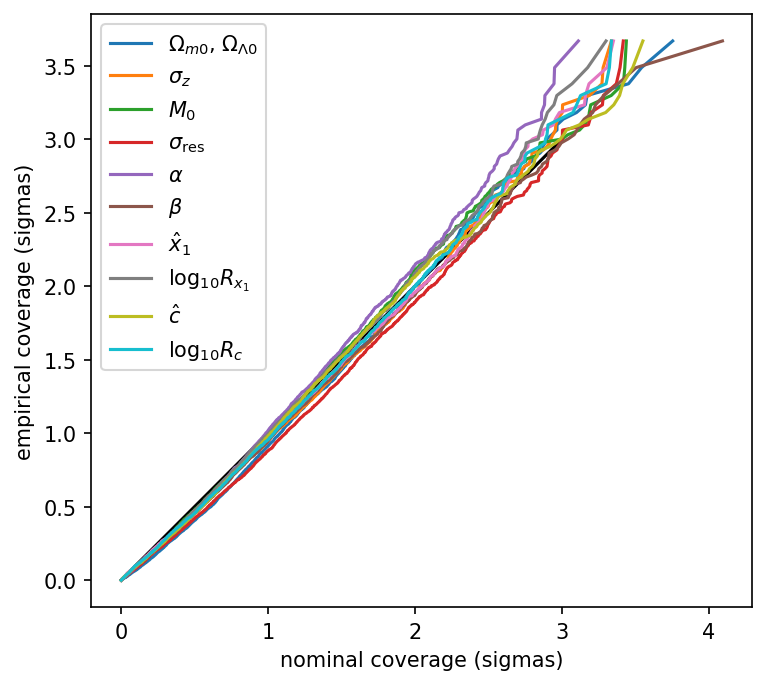

In [8]:
validator.plot_qq(qs, plt.figure(figsize=(5, 5)), sigmas=True);

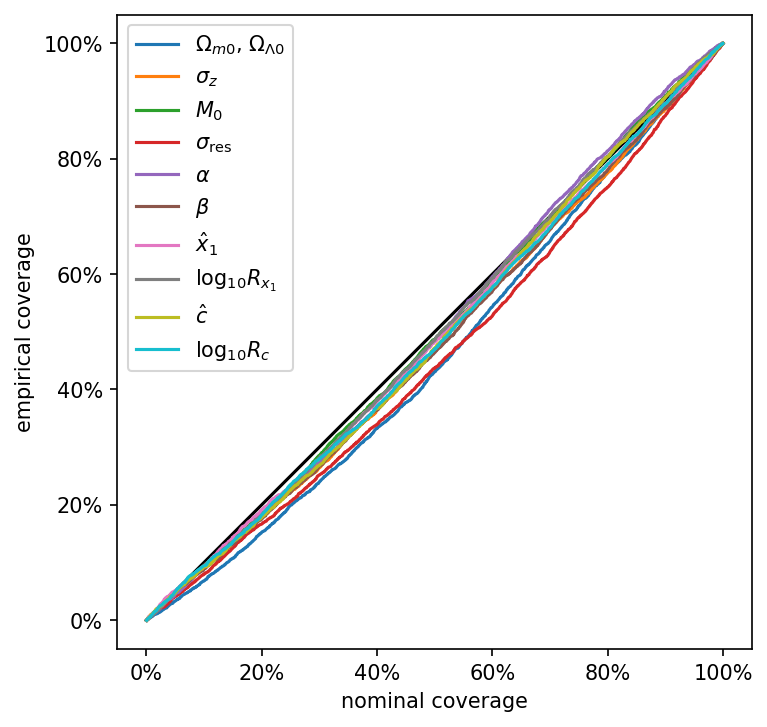

In [20]:
validator.plot_qq(qs, plt.figure(figsize=(5, 5)), sigmas=False);

#### TiKZ

In [19]:
from more_itertools import always_iterable


(qqdf := (qqdf := pd.DataFrame({
    '-'.join(always_iterable(group)): sorted(q)
    for group, q in qs.items()
})).set_index(np.linspace(0, 1, len(qqdf), endpoint=False) + 0.5/len(qqdf))).reset_index()[::10].to_csv('paper/plotdata/valid-qq.csv', index=False)
qqdf

,Om0-Ode0,sigma_z,mean_M0,sigma_res,alpha,beta,mean_x1,log10_R_x1,mean_c,log10_R_c
0.000122,0.000525,0.000622,0.000578,0.000883,0.000600,0.000812,0.000614,0.001063,0.000630,0.000530
0.000366,0.000639,0.000693,0.000826,0.000987,0.000645,0.001072,0.000661,0.001428,0.000721,0.000618
0.000610,0.000867,0.000733,0.001228,0.001645,0.000695,0.001170,0.000682,0.002320,0.000892,0.001121
0.000854,0.001330,0.000737,0.001310,0.002340,0.000925,0.001386,0.000687,0.002344,0.000942,0.001327
0.001099,0.001578,0.000986,0.001398,0.002408,0.001305,0.001589,0.001037,0.002650,0.001160,0.001439
...,...,...,...,...,...,...,...,...,...,...
0.998901,0.998476,0.998557,0.999145,0.998964,0.996065,0.998982,0.998415,0.996966,0.999304,0.998227
0.999146,0.999444,0.998930,0.999368,0.999246,0.996774,0.999278,0.998544,0.997847,0.999359,0.999033
0.999390,0.999601,0.998960,0.999389,0.999312,0.996814,0.999542,0.999050,0.998497,0.999501,0.999106
0.999634,0.999825,0.999150,0.999413,0.999366,0.998134,0.999957,0.999190,0.999031,0.999615,0.999150


### Norms

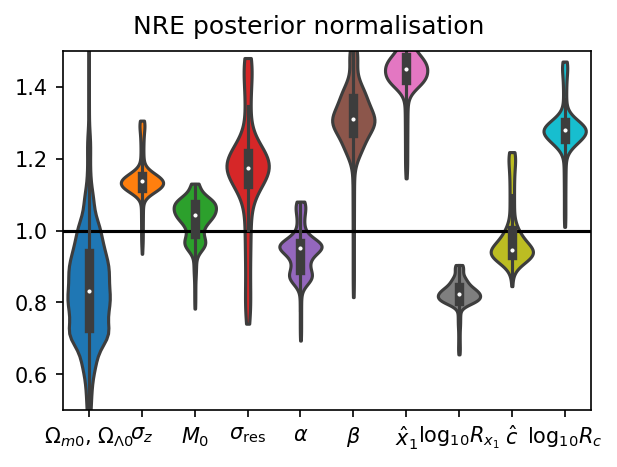

In [9]:
validator.plot_norms(norms_like, plt.figure(figsize=(4, 3), dpi=150));

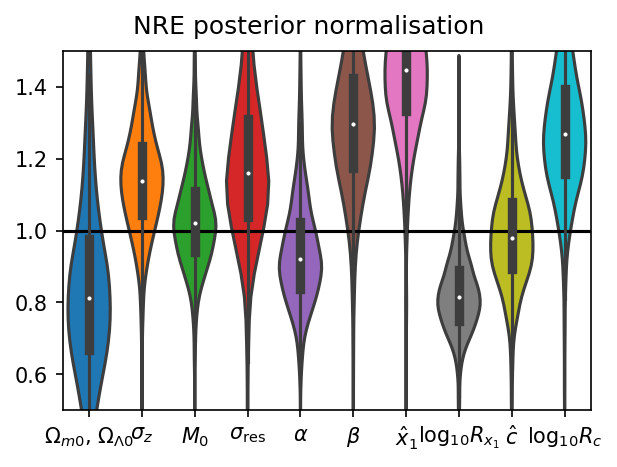

In [10]:
validator.plot_norms(norms_post, plt.figure(figsize=(4, 3), dpi=150));